In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [92]:
train = pd.read_csv("../cleaned_data/train_clenaed_IsolationForest.csv")
train

,individualnumber,category_number,hakkedis_amt,odul_amt,response,total_money_spent,total_discount,sanal_percent,shop_count,months_since_last_shopping,...,level1_relevant_category_volume,level2_relevant_category_volume,level3_relevant_category_volume,level4_relevant_category_volume,level1_relevant_category_quantity,level2_relevant_category_quantity,level3_relevant_category_quantity,level4_relevant_category_quantity,odul/hakkedis,is_large_city
0,94230288,9000,21.0,2.0,0,7118.94741,177.489978,0.015625,64.0,1.0,...,996.749,487.360,241.110,241.110,96.720,47.000,36.000,36.000,0.095238,True
1,4684087,9000,17.0,1.0,0,10192.64563,31907.260487,0.000000,30.0,1.0,...,461.227,105.900,105.900,105.900,35.080,12.000,12.000,12.000,0.058824,False
2,88026681,9030,22.0,2.0,0,11559.66676,231.976316,0.950000,40.0,1.0,...,308.150,138.650,138.650,138.650,14.000,8.000,8.000,8.000,0.090909,True
3,98127795,9001,38.0,3.0,0,461.77380,1.738800,0.000000,4.0,3.0,...,115.700,38.000,38.000,38.000,11.000,2.000,2.000,2.000,0.078947,False
4,101834804,9046,85.0,8.0,0,180.57000,19.349210,0.000000,6.0,1.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.094118,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12851,97214433,9059,27.0,2.0,0,16893.83688,1598.015176,0.009881,506.0,1.0,...,473.770,84.810,84.810,58.960,22.000,7.000,7.000,5.000,0.074074,True
12852,96841665,9004,65.0,6.0,0,13089.84113,500.344604,0.000000,40.0,1.0,...,408.990,250.750,250.750,250.750,22.000,5.000,5.000,5.000,0.092308,True
12853,98445787,9044,33.0,3.0,0,2432.60788,244.758629,0.000000,39.0,1.0,...,168.546,99.416,27.656,27.656,10.832,3.832,0.832,0.832,0.090909,False
12854,13781030,9004,66.0,6.0,0,1242.70635,6.080452,0.090909,11.0,1.0,...,68.500,68.500,68.500,68.500,1.000,1.000,1.000,1.000,0.090909,False


In [63]:
quantile_selection = "total_discount"
quantile_limit_selection = 0.9

limit = train[quantile_selection].quantile(quantile_limit_selection)
train_lower = train[train[quantile_selection] < limit]

print(train.response.value_counts())
print(train_lower.response.value_counts())


0    12647
1      209
Name: response, dtype: int64
0    11508
1       62
Name: response, dtype: int64


/var/folders/p4/w5cgd6hs1tsd7tddgjp26yn80000gn/T/ipykernel_53297/1748522309.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_lower.corr()


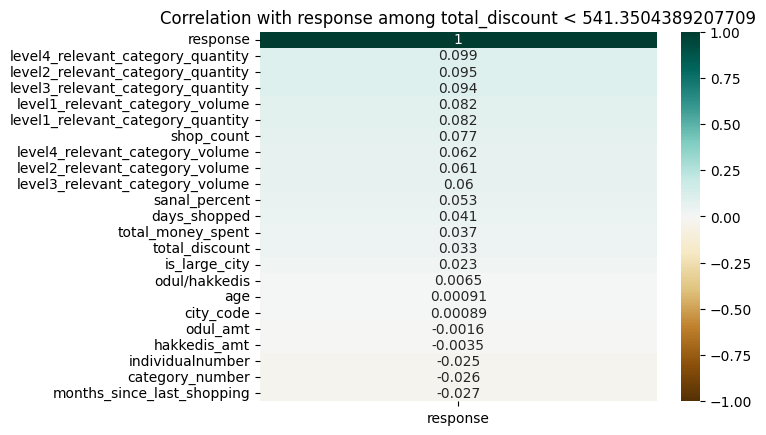

In [64]:
correlation = train_lower.corr()

sns.heatmap(correlation[['response']].sort_values(by='response', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title(f"Correlation with response among {quantile_selection} < {limit}")
plt.show()

In [82]:
# Anomaly detection among response = 0 using sklearn.IsolationForest
anomalies = 0.01


clf = IsolationForest(n_estimators=100, warm_start=True)
_train_lower = train_lower.copy()
x = _train_lower[_train_lower["response"] == 0]

# to_model_columns = ["level1_relevant_category_volume", "level2_relevant_category_volume", "level3_relevant_category_volume", "level4_relevant_category_volume", "level1_relevant_category_quantity", "level2_relevant_category_quantity", "level3_relevant_category_quantity", "level4_relevant_category_quantity"]
to_model_columns = ["level1_relevant_category_quantity", "level2_relevant_category_quantity", "level3_relevant_category_quantity", "level4_relevant_category_quantity", "total_money_spent", "sanal_percent", "days_shopped", "months_since_last_shopping", "shop_count"]

from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=anomalies, \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(x[to_model_columns])
pred = clf.predict(x[to_model_columns])

x['anomaly']=pred
outliers=x.loc[x['anomaly']==-1]


outlier_index=list(outliers.index)

# Find the number of anomalies and normal points here points classified -1 are anomalous
print(x['anomaly'].value_counts())
x_anomalies = x[x["anomaly"] == -1]


train_lower_anomalies_dropped = pd.merge(_train_lower, x_anomalies[["individualnumber", "anomaly"]], how="left", on="individualnumber")
train_lower_anomalies_dropped.fillna(1, inplace=True)
train_lower_anomalies_dropped = train_lower_anomalies_dropped[train_lower_anomalies_dropped["anomaly"] != -1]
train_lower_anomalies_dropped.drop(columns="anomaly", inplace=True)
train_lower_anomalies_dropped

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    11392
-1      116
Name: anomaly, dtype: int64


/var/folders/p4/w5cgd6hs1tsd7tddgjp26yn80000gn/T/ipykernel_53297/1818505520.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['anomaly']=pred


,individualnumber,category_number,hakkedis_amt,odul_amt,response,total_money_spent,total_discount,sanal_percent,shop_count,months_since_last_shopping,...,level1_relevant_category_volume,level2_relevant_category_volume,level3_relevant_category_volume,level4_relevant_category_volume,level1_relevant_category_quantity,level2_relevant_category_quantity,level3_relevant_category_quantity,level4_relevant_category_quantity,odul/hakkedis,is_large_city
0,94230288,9000,21.0,2.0,0,7118.94741,177.489978,0.015625,64.0,1.0,...,996.749,487.360,241.110,241.110,96.720,47.000,36.000,36.000,0.095238,True
1,88026681,9030,22.0,2.0,0,11559.66676,231.976316,0.950000,40.0,1.0,...,308.150,138.650,138.650,138.650,14.000,8.000,8.000,8.000,0.090909,True
2,98127795,9001,38.0,3.0,0,461.77380,1.738800,0.000000,4.0,3.0,...,115.700,38.000,38.000,38.000,11.000,2.000,2.000,2.000,0.078947,False
3,101834804,9046,85.0,8.0,0,180.57000,19.349210,0.000000,6.0,1.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.094118,False
4,94125442,9007,19.0,1.0,0,3324.36619,64.822990,0.000000,25.0,2.0,...,140.600,12.200,12.200,12.200,17.000,2.000,2.000,2.000,0.052632,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11565,100965008,9017,22.0,2.0,0,2679.46865,169.780473,0.033333,30.0,1.0,...,326.197,204.050,157.900,157.900,43.050,36.000,28.000,28.000,0.090909,True
11566,96841665,9004,65.0,6.0,0,13089.84113,500.344604,0.000000,40.0,1.0,...,408.990,250.750,250.750,250.750,22.000,5.000,5.000,5.000,0.092308,True
11567,98445787,9044,33.0,3.0,0,2432.60788,244.758629,0.000000,39.0,1.0,...,168.546,99.416,27.656,27.656,10.832,3.832,0.832,0.832,0.090909,False
11568,13781030,9004,66.0,6.0,0,1242.70635,6.080452,0.090909,11.0,1.0,...,68.500,68.500,68.500,68.500,1.000,1.000,1.000,1.000,0.090909,False


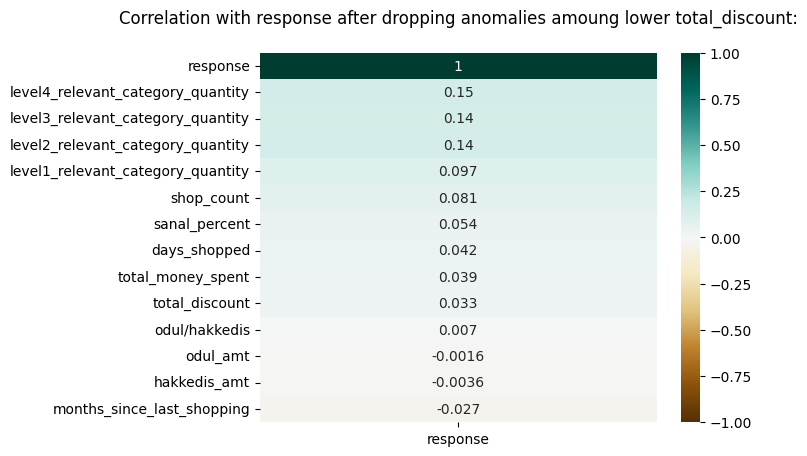

In [83]:
correlation = train_lower_anomalies_dropped[["response", "level1_relevant_category_quantity", "level2_relevant_category_quantity", "level3_relevant_category_quantity", "level4_relevant_category_quantity", "sanal_percent", "total_discount", "total_money_spent", "days_shopped", "months_since_last_shopping", "shop_count", "odul_amt", "hakkedis_amt", "odul/hakkedis"]].corr()

sns.heatmap(correlation[['response']].sort_values(by='response', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title(f"Correlation with response after dropping anomalies amoung lower {quantile_selection}:\n")
plt.show()

In [84]:
train_higher = train[train[quantile_selection] >= limit]
train_higher

,individualnumber,category_number,hakkedis_amt,odul_amt,response,total_money_spent,total_discount,sanal_percent,shop_count,months_since_last_shopping,...,level1_relevant_category_volume,level2_relevant_category_volume,level3_relevant_category_volume,level4_relevant_category_volume,level1_relevant_category_quantity,level2_relevant_category_quantity,level3_relevant_category_quantity,level4_relevant_category_quantity,odul/hakkedis,is_large_city
1,4684087,9000,17.0,1.0,0,10192.64563,31907.260487,0.000000,30.0,1.0,...,461.227,105.900,105.900,105.900,35.080,12.000,12.000,12.000,0.058824,False
5,94859143,9044,27.0,2.0,0,7476.54803,629.911821,0.000000,94.0,1.0,...,680.447,298.247,278.347,278.347,31.426,12.426,11.426,11.426,0.074074,True
13,97816022,9018,22.0,2.0,0,16350.25982,3906.563784,0.000000,37.0,1.0,...,516.820,236.700,236.700,236.700,32.642,15.000,15.000,15.000,0.090909,True
34,81184194,9022,45.0,6.0,0,21230.95353,1287.873982,0.000000,81.0,1.0,...,3192.440,2085.150,320.310,320.310,85.000,50.000,16.000,16.000,0.133333,True
38,93139089,9059,27.0,2.0,0,3020.50464,544.798214,0.000000,36.0,1.0,...,1274.940,1236.690,37.870,37.870,20.000,16.000,5.000,5.000,0.074074,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12817,94262923,9037,30.0,3.0,0,4737.56560,740.203281,0.000000,52.0,3.0,...,148.950,84.150,84.150,84.150,10.000,5.000,5.000,5.000,0.100000,True
12820,93388025,9003,7.0,1.0,0,8761.31321,903.780019,0.000000,37.0,1.0,...,315.070,6.700,6.700,6.700,14.000,2.000,2.000,2.000,0.142857,False
12821,93043680,9005,16.0,2.0,0,33650.59055,1716.532926,0.017544,57.0,1.0,...,2224.100,149.700,0.000,0.000,63.000,12.000,0.000,0.000,0.125000,True
12847,44549325,9018,15.0,1.0,0,6938.14510,12230.292183,0.000000,76.0,1.0,...,123.370,106.600,106.600,106.600,17.000,14.000,14.000,14.000,0.066667,True


In [89]:
train_new = train_higher.append(train_lower_anomalies_dropped, ignore_index=True)
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12740 entries, 0 to 12739
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   individualnumber                   12740 non-null  int64  
 1   category_number                    12740 non-null  int64  
 2   hakkedis_amt                       12740 non-null  float64
 3   odul_amt                           12740 non-null  float64
 4   response                           12740 non-null  int64  
 5   total_money_spent                  12740 non-null  float64
 6   total_discount                     12740 non-null  float64
 7   sanal_percent                      12740 non-null  float64
 8   shop_count                         12740 non-null  float64
 9   months_since_last_shopping         12740 non-null  float64
 10  days_shopped                       12740 non-null  float64
 11  gender                             12740 non-null  obj

/var/folders/p4/w5cgd6hs1tsd7tddgjp26yn80000gn/T/ipykernel_53297/4235646617.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_new = train_higher.append(train_lower_anomalies_dropped, ignore_index=True)


In [93]:
# Output the cleaned data into csv file:
path = "../cleaned_data/"

train_new.to_csv(f"{path}/train_cleaned_IsolationForest_low_adjusted.csv", index=False)